# Basic engine implementation

#### setup

In [13]:
import face_recognition, PIL.Image, PIL.ImageDraw,math
import numpy as np
import logging
import cv2
import platform
from matplotlib import pyplot as plt
from PIL import Image
import scipy.signal as sig

FORMAT = '[%(asctime)s] [%(levelname)s] [%(funcName)s] [%(lineno)d] : %(message)s'
logging.basicConfig(format=FORMAT, level=logging.INFO)

logging.info("Starting ...")
if platform.system() == "Windows":
    seperator = "\\"
else:
    seperator = "/"

dir = "perry-all-2"
# should be a parameter of the engine
dataset_location = ".." + seperator + "dataset" + seperator + "good_sync" + seperator
specific_dir = dir
video_location = dataset_location + specific_dir + seperator + "test1.mp4"
video_location = './eyal7.mp4'

[2021-05-08 09:52:49,665] [INFO] [<module>] [13] : Starting ...


## running evm pre-processing

In [14]:
# %run ./evm_preprocessing.ipynb
# video_location = dataset_location + specific_dir + seperator + "out.avi"
# video_location="out2.avi"

#### Detecting the face landmarks and parsing the ROI

In [15]:
def parse_roi(frame):
    # image = face_recognition.load_image_file(frame) # read image.
    face_locations = face_recognition.face_locations(frame,model = 'hog') # detects all the faces in image
    face_landmarks_list = face_recognition.face_landmarks(image)
    
    # iterate through all the faces.
    for face_location in face_locations:
        img = PIL.Image.fromarray(frame)
        top,right,bottom,left = face_location # extract all face square points.
        diff = math.floor((top - bottom) * 0.15) # 20 percent of the face len (to add eyebrow top point).
        
        # finding the forehead
        try:
            right_eyebrow_landmarks = np.asarray(face_landmarks_list[0]['right_eyebrow']) # right eyebrow points.
        except:
            return None
        right_eyebrow_landmarks.sort(axis=0)
        rightest_point = right_eyebrow_landmarks[-1] # The most right point of the ROI(according to x).
        top_right_eyebrow = right_eyebrow_landmarks.min(axis = 0)[1]
        try:
            left_eyebrow_landmarks = np.asarray(face_landmarks_list[0]['left_eyebrow'])
        except:
            return None
        left_eyebrow_landmarks.sort(axis=0)
        leftest_point = left_eyebrow_landmarks[0] # the most left point of ROI.(according to x)
        top_left_eyebrow = left_eyebrow_landmarks.min(axis = 0)[1]
        bottom = min(top_right_eyebrow,top_left_eyebrow).item(0) # bottom point of the forehead.
        bottom = bottom - (0.05 * bottom) # improve bottom location by 2 percent.
        forehead = img.crop((leftest_point[0], leftest_point[1]+diff, rightest_point[0],bottom+10)) # adding diff to top to make the forehead bigger.

        # finding the second ROI:
        try:
            upper_mouth = np.asarray(face_landmarks_list[0]['top_lip']) # top_lip landmarks
        except:
            return None
        upper_mouth_min = upper_mouth.min(axis = 0)[1] # The  top - lip upper point.
        try:
            upper_nose = np.asarray(face_landmarks_list[0]['nose_bridge'])
        except:
            return None
        upper_nose_min = upper_nose.min(axis = 0)[1]  # noise bridge upper point.
        upper_nose_min += upper_mouth_min * 0.1 # improving the noise bridge upper point.
        nose_to_upper_lip = img.crop((leftest_point[0], upper_nose_min, rightest_point[0], upper_mouth_min))

        return forehead, nose_to_upper_lip
    return None # in case of which no face was detected

### Check for bad frames
##### R > 95 and G > 40 and B > 20 and R > G and R > B
##### Based on https://arxiv.org/ftp/arxiv/papers/1708/1708.02694.pdf page 5

In [16]:
red_min_val = 95
green_min_val = 40
blue_min_val = 20
red_green_max_diff = 15
def good_frame(blue, green, red):
    if red <= red_min_val:
        logging.warning("bad frame detected, reason: red > red_min_val")
        return False
    if green <= green_min_val:
        logging.warning("bad frame detected, reason: green > green_min_val")
        return False
    if blue <= blue_min_val:
        logging.warning("bad frame detected, reason: blue > blue_min_val")
        return False
    if red <= green:
        logging.warning("bad frame detected, reason: red > green")
        return False
    if red <= blue:
        logging.warning("bad frame detected, reason: red > blue")
        return False
    if abs(red - green) <= red_green_max_diff:
        logging.warning("bad frame detected, reason: abs(red - green) > red_green_max_diff")
        return False

    return True

In [17]:
def get_new_frame(vidcap):
    success, next_image = vidcap.read()
    return success, next_image

#### Plotting RGB arrays results

In [18]:
def plot_result(greens, reds, blues, x_value, title=""):
    logging.info("Plotting results ..." + title)
    plt.figure(figsize=(6, 5))
    plt.title(title)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.subplot(3, 1, 1)
    plt.plot(x_value, greens, color="green")
    plt.subplot(3, 1, 2)
    plt.plot(x_value, reds, color="red")
    plt.subplot(3, 1, 3)
    plt.plot(x_value, blues, color="blue")
    plt.show()
    logging.info("Showing result")

#### Filtering:

In [19]:
def filter_channel(channel,fs):
    """
    This method apply filter on a channel between 0.75HZ to 4HZ.
    :param channel: Is a signal to apply the filter to.
    :param fs: Is the sampling rate of channel.
    :return: The filtered channel.
    """
    bh, ah = sig.butter(4, 0.75 / (fs / 2), 'highpass')
    bl, al = sig.butter(4, 4 / (fs / 2), 'lowpass')
    channel = sig.filtfilt(bh, ah, channel) # applying the filter coefficient on the sig
    #channel = np.absolute(channel)
    channel_after_filter = sig.filtfilt(bl, al, channel) # applying the filter coefficient on the sig
    return channel_after_filter

#### Getting RGB values from a frame and adding them to arrays

In [20]:
def parse_luminace(red, green, blue):
    luminance_level = 0.2126 * red + 0.7152 * green + 0.0722 * blue
    return luminance_level
def parse_RGB(roi, color_sig):
    """
    Parses an image to its RGB channels
    :param image: the image to be parsed
    :param vidcap:
    :param greens: array containing green channel values
    :param blues: array containing blue channel values
    :param reds: array containing red channel values
    :param frame_number - is the number of the frame of the video.
    :return: a flag indicating if there is a next image, and the next image
    """
#     plt.imshow(roi)
#     plt.show()
    try:
        for r in roi:
            cv2.cvtColor(r, cv2.COLOR_RGB2BGR)
    except:
        return False, color_sig
    for r,i in enumerate(roi):
        new_blue,new_green,new_red = cv2.split(r)
        b_mean,g_mean,r_mean = np.mean(new_blue),np.mean(new_green),np.mean(new_red)
        luminance_level = parse_luminace(r_mean, g_mean, b_mean)
        if good_frame(b_mean,g_mean,r_mean):
            color_channels = r.reshape(-1, r.shape[-1])
            avg_color = color_channels.mean(axis=0)
            color_sig[i].append(avg_color)
            return True, color_sig, luminance_level
    return False, color_sig, luminance_level

#### Main loop - going over all the frames of the video

In [21]:
color_sig = [[]]
heart_rates = []
good_frame_number = 0
total_frame_number = 0

# Parsing video:
logging.info("Working on video " + video_location)
vidcap = cv2.VideoCapture(video_location)
success, image = vidcap.read()
fps = vidcap.get(cv2.CAP_PROP_FPS) # fs == sampling rate
round_fps = np.round(fps)
number_of_frames = vidcap.get(cv2.CAP_PROP_FRAME_COUNT)
logging.info("Parsing images ...")
while success:
    logging.info("parsing frame " + str(total_frame_number) + "/" + str(number_of_frames))
    rois = parse_roi(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))  # build image ROI (rois is a tuple contains two regions)
    if rois is not None : 
#         roi = np.asarray(rois[0]) # Just the forehead
        roi = np.vstack((rois[0], rois[1]))
        is_good_frame,color_sig, luminance_level = parse_RGB(roi, color_sig)
        if is_good_frame:
            good_frame_number += 1
            logging.info("luminance level: " + str(luminance_level))
    total_frame_number += 1
    success, image = get_new_frame(vidcap)


[2021-05-08 09:52:49,732] [INFO] [<module>] [7] : Working on video ./eyal7.mp4
[2021-05-08 09:52:49,786] [INFO] [<module>] [13] : Parsing images ...
[2021-05-08 09:52:49,786] [INFO] [<module>] [15] : parsing frame 0/1229.0
[2021-05-08 09:52:51,648] [INFO] [<module>] [15] : parsing frame 1/1229.0
[2021-05-08 09:52:53,457] [INFO] [<module>] [15] : parsing frame 2/1229.0
[2021-05-08 09:52:55,262] [INFO] [<module>] [15] : parsing frame 3/1229.0
[2021-05-08 09:52:57,064] [INFO] [<module>] [15] : parsing frame 4/1229.0
[2021-05-08 09:52:58,866] [INFO] [<module>] [15] : parsing frame 5/1229.0
[2021-05-08 09:53:00,684] [INFO] [<module>] [15] : parsing frame 6/1229.0
[2021-05-08 09:53:02,558] [INFO] [<module>] [15] : parsing frame 7/1229.0
[2021-05-08 09:53:04,424] [INFO] [<module>] [15] : parsing frame 8/1229.0
[2021-05-08 09:53:06,286] [INFO] [<module>] [15] : parsing frame 9/1229.0
[2021-05-08 09:53:08,152] [INFO] [<module>] [15] : parsing frame 10/1229.0
[2021-05-08 09:53:09,984] [INFO] [<m

ValueError: all the input arrays must have same number of dimensions, but the array at index 0 has 2 dimension(s) and the array at index 1 has 3 dimension(s)

In [ ]:
def print_results(window_sig, window, xlabel, ylabel, change_range):
    fig = plt.figure()
    ax = fig.subplots()
    while len(window_sig) > len(window):
        window_sig = window_sig[-1]
    ax.plot(window_sig,window,color ='green')
    if change_range:
        plt.xlim([0, 5])

    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_xscale('linear')
    ax.spines['bottom'].set_color('red')
    ax.spines['left'].set_color('red')
    ax.xaxis.label.set_color('red')
    ax.yaxis.label.set_color('red')
    ax.tick_params(axis='x', colors='red')
    ax.tick_params(axis='y', colors='red')
    plt.show()

def find_hr_in_window(green, window_start, round_fps, window_id, window_size):
    round_fps = int(round_fps)
    if window_start + round_fps * window_size > len(green):
        window = green[window_start : ]
    else:
        window = green[window_start : window_start + round_fps * window_size]
    window_sig = np.arange(window.size/round_fps,step= (1/30))

    print_results(window_sig, window, 'X-axis', 'Y-axis', False)

    window = window - np.mean(window)
    window = window / np.std(window)
    print_results(window_sig, window, 'X-axis', 'Y-axis', False)

    g = filter_channel(window,round_fps)
    print_results(window_sig, g, 'X-axis', 'Y-axis', False)

    f, Pxx_den = sig.periodogram(g, round_fps)

    print_results(f, Pxx_den, 'frequency [Hz]', 'PSD [V**2/Hz]', True)
    # plt.semilogy(f, Pxx_den)
    # plt.ylim([1e-7, 1e2])
    # plt.xlabel('frequency [Hz]')
    # plt.ylabel('PSD [V**2/Hz]')
    # plt.show()


    max_val = Pxx_den.argmax()
    logging.info("Heart rate of window " + str(window_id) +
                 ": " + str(f[max_val]))

In [ ]:
# color_sig_array = np.asarray(color_sig)
# red = color_sig_array[:,0]
# green = color_sig_array[:,1]
# blue = color_sig_array[:,2]
# 
# window_start = 0
# window_size = 30
# window_id = 0
# limit = good_frame_number - int(round_fps) * window_size
# while window_start < limit :
#     find_hr_in_window(green, window_start, round_fps, window_id, window_size)
#     window_start += int(round_fps) * window_size
#     window_id += 1
# if window_start < good_frame_number:
#     window_id += 1
#     find_hr_in_window(green, window_start, round_fps, window_id, good_frame_number - window_start)

(2, 1024)


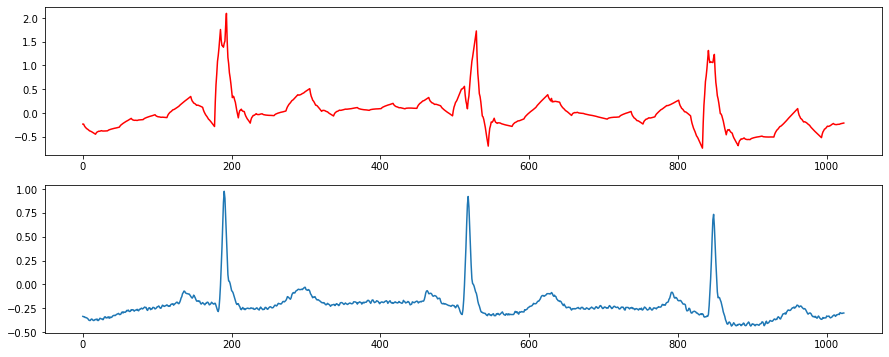

In [14]:
import pywt
from sklearn.decomposition import PCA
from sklearn.covariance import MinCovDet as MCD
import numpy as np
from sklearn.preprocessing import StandardScaler
from skimage.restoration import denoise_wavelet
from matplotlib import pyplot as plt
import numpy as np
import scipy,itertools
from skimage.restoration import denoise_wavelet

def eigenvalue_decomposition(mat):
        """ return (diagonal,orthogonal matrix)
        """
        """
        """
        # eigen_vals, eigen_vectors
        eigen_vals, eigen_vectors = np.linalg.eigh(mat)
        d = np.diag(eigen_vals)
        return d,eigen_vectors

def cartesian_product(xi,v):
    cartez_prod = list(itertools.product(xi,v))
    return np.asarray(cartez_prod).T
    
def multivariate_video_signal(signal):
    """
    Algorithm 1
    :param signal: is a 2D signal. One dimension the signal from the forehead, and second is from above the upper lip
    :return: multivariate PPG!
    """
    H, J = 2, 4
    num_of_sampels = signal.shape[1]
    wavelet = pywt.Wavelet('sym2') 
    coeff_all = pywt.wavedec(signal, wavelet, level=J) 
    approx_4,det_4,det_3,det_2,det_1 = coeff_all
    details = [det_1,det_2,det_3,det_4]
    noise_mat = MCD(random_state=0).fit(details[0].T).covariance_
    # decomposing noise matrix: 
    d,v = eigenvalue_decomposition(noise_mat) # noise_matrix = v * d *v.T
    diag_vals = d.diagonal()
    xi_hats = []
    for j in range(0, J ):
        xi_j = np.dot(details[j].T,v).T
#         xi_j = cartesian_product(details[j].T,v)
        xi_hat_hs = []
        for h in range(0, H):
            gama_h = np.sqrt(2 * diag_vals[h] * np.log(num_of_sampels))
            xi_hat_hs.append(pywt.threshold(data=xi_j[h], value=gama_h))
        xi_hats.append(np.vstack((xi_hat_hs[0],xi_hat_hs[1])))
    # scaling function basis change:
    phi = approx_4.T
    pca = PCA()
    phi_norm = StandardScaler().fit_transform(phi) # normalize 
    pca.fit(phi_norm)
    phi_hat = pca.transform(phi_norm).T # new scaling function
    #reconstructing the signal:
    coeffs = list(reversed(xi_hats))
    coeffs.insert(0,phi_hat) # coeeffs is in a form of [cA4,cD4,cD3,cD2,cD1]
    multivariate_ppg = pywt.waverec(coeffs,wavelet) # reconstruction
    return multivariate_ppg

# data that i used to test the algorithm:
# x = pywt.data.ecg().astype(float) / 256
# y = pywt.data.ecg().astype(float) / 256
# sigma = 0.05
# x_noisy = x + sigma * np.random.randn(x.size)
# y_noisy = x + 2*sigma * np.random.randn(y.size)
# combined = np.vstack((x_noisy, y_noisy)) # making 2d array
ppg_hat = multivariate_video_signal(color_sig)
plt.figure(figsize=(15,6))
plt.subplot(2,1,1)
plt.plot(ppg_hat[0],"red")
plt.subplot(2,1,2)

# plt.plot(ppg_hat,color = 'red')


In [25]:
# Peaks detection + write to csv the times

(637,)


ValueError: Input array has fewer dimensions than the specified axes

# Peaks detection + write to csv the times

In [ ]:
import pandas as pd
def indexes(y, thres=0.3, min_dist=1, thres_abs=False):
    if isinstance(y, np.ndarray) and np.issubdtype(y.dtype, np.unsignedinteger):
        raise ValueError("y must be signed")

    if not thres_abs:
        thres = thres * (np.max(y) - np.min(y)) + np.min(y)

    min_dist = int(min_dist)

    # compute first order difference
    dy = np.diff(y)

    # propagate left and right values successively to fill all plateau pixels (0-value)
    zeros, = np.where(dy == 0)

    # check if the signal is totally flat
    if len(zeros) == len(y) - 1:
        return np.array([])

    if len(zeros):
        # compute first order difference of zero indexes
        zeros_diff = np.diff(zeros)
        # check when zeros are not chained together
        zeros_diff_not_one, = np.add(np.where(zeros_diff != 1), 1)
        # make an array of the chained zero indexes
        zero_plateaus = np.split(zeros, zeros_diff_not_one)

        # fix if leftmost value in dy is zero
        if zero_plateaus[0][0] == 0:
            dy[zero_plateaus[0]] = dy[zero_plateaus[0][-1] + 1]
            zero_plateaus.pop(0)

        # fix if rightmost value of dy is zero
        if len(zero_plateaus) and zero_plateaus[-1][-1] == len(dy) - 1:
            dy[zero_plateaus[-1]] = dy[zero_plateaus[-1][0] - 1]
            zero_plateaus.pop(-1)

        # for each chain of zero indexes
        for plateau in zero_plateaus:
            median = np.median(plateau)
            # set leftmost values to leftmost non zero values
            dy[plateau[plateau < median]] = dy[plateau[0] - 1]
            # set rightmost and middle values to rightmost non zero values
            dy[plateau[plateau >= median]] = dy[plateau[-1] + 1]

    # find the peaks by using the first order difference
    peaks = np.where(
        (np.hstack([dy, 0.0]) < 0.0)
        & (np.hstack([0.0, dy]) > 0.0)
        & (np.greater(y, thres))
    )[0]

    # handle multiple peaks, respecting the minimum distance
    if peaks.size > 1 and min_dist > 1:
        highest = peaks[np.argsort(y[peaks])][::-1]
        rem = np.ones(y.size, dtype=bool)
        rem[peaks] = False

        for peak in highest:
            if not rem[peak]:
                sl = slice(max(0, peak - min_dist), peak + min_dist + 1)
                rem[sl] = True
                rem[peak] = False

        peaks = np.arange(y.size)[~rem]

    return peaks
green_buttered = filter_channel(green,round_fps)
peaks = indexes(green_buttered,min_dist=20)
# peaks, _ = sig.find_peaks(x, height=0.75)
x = np.arange(window_size,step=1/round_fps)
plt.plot(x,green_buttered,'-go',markerfacecolor='red',markevery=peaks)
plt.show()
np.savetxt("time_of_peaks.csv", x[peaks], delimiter=",")

In [ ]:
# a = Pxx_den
# ind = np.argsort(a)
# max_ind = ind[-5:]
# print(f[max_ind])
# print("HR for this video is: " +str(f[max_ind].mean()))

In [ ]:
# if good_frame_number != greens.size: # TO BE REVIEW BY EYAL, POSSIBLE BUG FIX HERE!
#     frame_number = greens.size
# axis = np.arange((good_frame_number / round_fps), step=(1 / 30)) # axis is Time
# plot_result(greens, reds, blues, axis, "All 3 channels") # original signals
# # apply filtering on all the channels:
# green_buttered = filter_channel(greens,round_fps)
# red_buttered = filter_channel(reds,round_fps)
# blue_buttered = filter_channel(blues,round_fps)
# # plotting the channels after apllying the filter
# plot_result(green_buttered, red_buttered, blue_buttered, axis, "After Filter") # after filtering

In [ ]:
# if good_frame_number != greens.size: # TO BE REVIEW BY EYAL, POSSIBLE BUG FIX HERE!
#     frame_number = greens.size
# axis = np.arange((good_frame_number / round_fps), step=(1 / 30)) # axis is Time
# plot_result(greens, reds, blues, axis, "All 3 channels") # original signals
# # apply filtering on all the channels:
# green_buttered = filter_channel(greens,round_fps)
# red_buttered = filter_channel(reds,round_fps)
# blue_buttered = filter_channel(blues,round_fps)
# # plotting the channels after apllying the filter
# plot_result(green_buttered, red_buttered, blue_buttered, axis, "After Filter") # after filtering

### PSD estimation using 'Welch' or 'Periodogram'

In [ ]:
# f, Pxx_den = sig.welch(green_buttered, round_fps,'flattop', 1024, scaling='spectrum')

### Plot final results

In [4]:
# plt.figure(f, Pxx_den)
# #plt.semilogy(f, Pxx_den)
# plt.ylim([1e-7, 1e2])
# plt.xlabel('frequency [Hz]')
# plt.ylabel('PSD [V**2/Hz]')
# plt.show()
# # periodogram method:
# f, Pxx_den = sig.periodogram(green_buttered, round_fps)
# plt.semilogy(f, Pxx_den)
# plt.ylim([1e-7, 1e2])
# plt.xlabel('frequency [Hz]')
# plt.ylabel('PSD [V**2/Hz]')
# plt.show()

